In [87]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%aimport model 
%aimport simulation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
import os.path
from datetime import datetime
import numpy as np
from scipy import linalg
from pylab import *
from matplotlib.backends.backend_pdf import PdfPages
import h5py
from sklearn.decomposition.factor_analysis import FactorAnalysis

from model import *
import simulation

# No spike regression

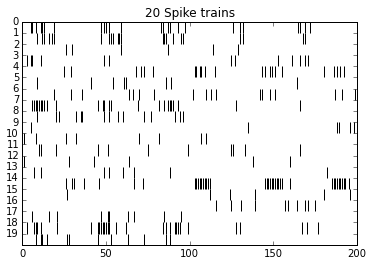

In [110]:
np.random.seed(0)

T = 200
w = 1e-4
std = 1
p = 0
L = 2
N = 20

high = np.log(25 / T)
low = np.log(5 / T)

# simulate latent processes
# x, ticks = simulation.latents(L, T, std, w)
x = np.empty((T, L), dtype=float)
x[:T // 2, 0] = high
x[T // 2:, 0] = low
x[:, 1] = 2 * np.sin(np.linspace(0, 2 * np.pi * 5, T))
for l in range(L):
    x[:, l] -= np.mean(x[:, l])

# simulate spike trains
a = 2 * np.random.rand(L, N) - 1
for l in range(L):
    a[l, :] /= linalg.norm(a[l, :]) / np.sqrt(N)

b = np.empty((1 + p*N, N))
b[0, :] = low

y, _, rate = simulation.spikes(x, a, b, intercept=True)
figure()
ylim(0, N)
for n in range(N):
    vlines(np.arange(T)[y[:, n] > 0], n, n + 1, color='black')
title('{} Spike trains'.format(N))
yticks(range(N))
gca().invert_yaxis()

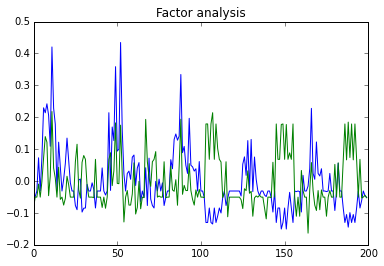

In [111]:
fa = FactorAnalysis(n_components=L)
m0 = fa.fit_transform(y)
a0 = fa.components_
# a0 = np.random.randn(L, N)
m0 *= np.linalg.norm(a0) / np.sqrt(N)
a0 /= np.linalg.norm(a0) / np.sqrt(N)

mu = np.zeros_like(x)

figure()
plot(m0)
title('Factor analysis')

In [112]:
var = np.empty(L, dtype=float)
var[0] = 5
var[1] = 5
w = np.empty(L, dtype=float)
w[0] = 1e-3
w[1] = 1e-3

control = {'max iteration': 100,
           'fixed-point iteration': 3,
           'tol': 1e-5,
           'verbose': True}

lbound, m1, V1, a1, b1, new_var, new_scale, a0, b0, elapsed, converged = train(y, 0, mu, var, w,
                                                               a0=a0,
                                                               b0=None,
                                                               m0=m0,
                                                               V0=None,
                                                               guardV=False, guardSigma=False,
                                                               fixalpha=False, fixbeta=False, fixpostmean=False,
                                                               fixpostcov=False,
                                                               normofalpha=np.sqrt(N), intercept=True,
                                                               hyper=True,
                                                               control=control)


Iteration[1]
lower bound = -2115.42045
increment = 47942455.6525393054
change in alpha = 1.2813829654
change in beta = 0.9999991380
change in posterior mean = 0.3713404309
change in posterior covariance = 4.9961601632
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[2]
lower bound = -1249.59877
increment = 865.8216808621
change in alpha = 1.6952421002
change in beta = 1.3846922425
change in posterior mean = 0.4836395324
change in posterior covariance = 0.0612750851
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[3]
lower bound = -1144.03665
increment = 105.5621162574
change in alpha = 0.7290387413
change in beta = 1.5723274482
change in posterior mean = 0.9638518080
change in posterior covariance = 0.0474611423
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[4]
lower bound = -1139.78039
increment = 4.2562662815
change in alpha = 0.1876060261
change in beta = 1.1564320

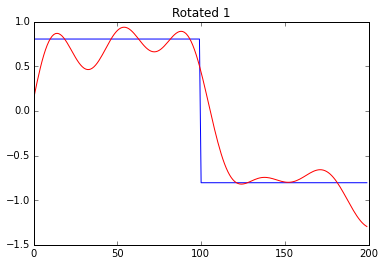

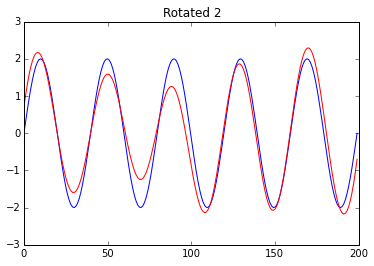

In [114]:
c = linalg.lstsq(m1, x)[0]
rotated = np.dot(m1, c)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='latent', color='blue')
    plot(rotated[:, l], label='transformed posterior', color='red')
    title('Rotated {}'.format(l + 1))